# 線形二値分類

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 二値分類の例：スパム判定

$\def\bm{\boldsymbol}$電子メールは誰にでもすぐにメッセージを送ることができるので便利である一方、自分が受け取りたくないスパムメール（迷惑メール）が送られてくることがある。[総務省の統計](https://www.soumu.go.jp/main_sosiki/joho_tsusin/d_syohi/m_mail.html)によると、電気通信事業者１０社の全受信メール数に対する[迷惑メール数の割合は約50%（2020年3月時点）](https://www.soumu.go.jp/main_content/000693529.pdf)である。そこで、多くのメールサーバやメールクライアントではスパムメールを自動で認識し、利用者の目に触れさせない機能（スパムフィルタ）が搭載されている。スパムフィルタの主なタスクは、与えられたメールがスパムであるか、スパムではないか自動的に判定することである。この判定を行うモジュール、すなわちスパム判定器を構築するのが、今回のお題である。

では、スパム判定器をどのように構築すればよいか。以下のスパムメールを具体例として考えたい。

![spam](fig/spam-s.png "スパムメールの例")

このメールの本文中で"I am Victoriya", "search for boy-friend", "Ny photos"などのフレーズが出てくることに着目し、これらのフレーズが本文中に含まれているメールをスパムと判定するには、次のようなルールを実装するかもしれない。

In [20]:
def is_spam(x):
    if x.find('I am Victoriya') != -1:
        return True
    if x.find('search for boy-friend') != -1:
        return True
    if x.find('Ny photos') != -1:
        return True
    #
    # ... (大量の判定ルール)
    #
    return False

In [22]:
is_spam('I am Victoriya, I am 27 y.o.')

True

In [23]:
is_spam('I search for boy-friend.')

True

このようにメールの本文に関して、スパムである条件を記述していくアプローチを**ルール**に基づく手法と呼ぶ。ルールに基づく手法は、訓練データが少ないときは迅速に作ることができる、スパムと判定する条件が明解であるという利点がある。一方で、スパムと判定する条件を詳細化するほどプログラムが複雑になるため、ルールの保守が難しい。また、英語のスパムメールのために作ったルールを、日本語のスパムメールに適用することができないため、特定の言語やジャンルにおけるメールにしか対応できない。

そこで、教師あり学習を用いてスパム判定器を構築することを考える。より具体的には、メールを$d$次元の説明変数$\bm{x} \in \mathbb{R}^d$で表現し、スパムメールか（$1$）スパムメールでないか（$0$）を表す目的変数（出力）$y \in \{0, 1\}$を考える。説明変数から目的変数を計算する関数$f: \mathbb{R}^d \longmapsto \{0, 1\}$を教師データ$\mathcal{D}$から学習することで、スパム判定器を構築できる。説明変数から$\{0, 1\}$などの離散値を取る目的変数を求めることを**分類**（classification）もしくは**識別**と呼ぶ。分類において目的変数が取りうる値は、**クラス**や**カテゴリ**などと呼ばれる。特に、説明変数の取りうる値が２つのクラスに限定された分類を、**二値分類**（binary classification）と呼ぶ。

以下の図は、機械学習によるスパムフィルターの典型的な動作を示している。スパムメールに関する教師データを使い、事前にスパム判定器を学習しておく。そして、与えられたメールに対して、スパム判定器はメールがスパムであるかどうか推定する。スパムと判定されたメールはスパムフォルダーに自動的に仕分けすることで、新着メールとして表示させないようにする。ただ、スパム判定器が間違った判定をしてしまうことがある。例えば、本当はスパムであるメールをスパムではないと判定してしまうと、新着メールとして表示されてしまう。このとき、メールを閲覧したユーザがそのメールにスパムであることの目印（フラグ）を付けたとする（スパムフォルダーに移動させてもよい）。これは、スパムメールの新しい学習事例を作ったことに相当する。そこで、この新しい学習事例を教師データとしてスパム判定器を再学習すると、スパム判定の性能が向上すると期待される。以降では、スパム判定などの二値分類を実現するモデルと、その学習方法や評価方法を説明する。

<img src="fig/spam-filter.svg" alt="スパム判定器" width="480px">

なお、スパムの語源はイギリスBBCが1970年頃に制作した『[空飛ぶモンティ・パイソン](https://ja.wikipedia.org/wiki/%E7%A9%BA%E9%A3%9B%E3%81%B6%E3%83%A2%E3%83%B3%E3%83%86%E3%82%A3%E3%83%BB%E3%83%91%E3%82%A4%E3%82%BD%E3%83%B3)』のスケッチ「[スパム](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%91%E3%83%A0_(%E3%83%A1%E3%83%BC%E3%83%AB))」から来ていると言われている（以下は2014年に行われた[復活ライブ](https://ja.wikipedia.org/wiki/%E3%83%A2%E3%83%B3%E3%83%86%E3%82%A3%E3%83%BB%E3%83%91%E3%82%A4%E3%82%BD%E3%83%B3_%E5%BE%A9%E6%B4%BB%E3%83%A9%E3%82%A4%E3%83%96!)の時に使われた
メニュー）。

<a title="Eduardo Unda-Sanzana from Antofagasta, Chile, CC BY 2.0 &lt;https://creativecommons.org/licenses/by/2.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Monty_Python_Live_02-07-14_13_04_42_(14598710791).jpg"><img width="256" alt="Monty Python Live 02-07-14 13 04 42 (14598710791)" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Monty_Python_Live_02-07-14_13_04_42_%2814598710791%29.jpg/256px-Monty_Python_Live_02-07-14_13_04_42_%2814598710791%29.jpg"></a>

メールのスパム判定以外にも、二値分類には様々な応用例がある。

+ 臨床検査: 血液検査やアンケートの回答などの説明変数から、患者の病気や異常の有無を判定する
+ 与信調査: 属性情報や過去の取引履歴から顧客の信用の有無を判定する
+ 当落予測: 世論調査や出口調査の結果から、候補者の当選・落選を予測する

## 線形二値分類

**線形二値分類** (linear binary classification) は、$d$次元の特徴ベクトルで表現された事例$\bm{x} \in \mathbb{R}^{d}$が与えられた時、線形モデルのパラメータ$\bm{w} \in \mathbb{R}^{d}$との内積を計算し、その正負によってラベル$\hat{y} \in \{1, 0\}$を推定する。

:::{admonition} 線形二値分類のラベル推定式
:class: important
$$
\begin{gather}
    \hat{y} = \begin{cases}
        1 & \left(\bm{x}^\top \bm{w} > 0\right) \\
        0 & (\mbox{それ以外})
    \end{cases}
\end{gather}
$$ (eq:binary-classification)
:::

スパム判定では、スパムメールを$\hat{y} = 1$、スパムではないメールを$\hat{y} = 0$などと定義する。二値分類において、$\hat{y} = 1$の事例を**正例**（positive example）、$\hat{y} = 0$の事例を**負例**（negative example）と呼ぶことがある。

メールがスパムであるか判定するための手がかりは色々考えられるが、ここでは簡単のため、$d=9$次元の特徴空間を例として用いる。この特徴空間の$1$次元目は、与えられたメールの本文に"attached"という単語が含まれるならば$1$、含まれなければ$0$とする。同様に、$2$次元目から$8$次元目まで、メール本文中に、それぞれ"darling", "file", "hi", "kyoto", "mark", "my", "photo"という単語が含まれるかどうかを表現する。$9$次元目はメールの内容に関わらず常に$1$とする。例えば、スパム判定を行いたいメールの本文が"Hi darling, my photo in attached file"であった場合、事例$\bm{x} \in \mathbb{R}^9$は、

\begin{gather}
 \bm{x} = \begin{pmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 1 & 1 & 1
\end{pmatrix}^\top
\end{gather}

線形二値分類は、事例$\bm{x}$とパラメータ$\bm{w}$の内積、
\begin{gather}
 \bm{x}^\top \bm{w} = \begin{pmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 1 & 1 & 1
\end{pmatrix} \begin{pmatrix}
w_1 \\
w_2 \\
w_3 \\
w_4 \\
w_5 \\
w_6 \\
w_7 \\
w_8 \\
w_9
\end{pmatrix} =w_1 + w_2 + w_3 + w_4 + w_7 + w_8 + w_9
\end{gather}
を計算し、その符号が正ならば事例をスパム（$\hat{y} = 1$）と判定し、$0$以下ならばスパムでない（$\hat{y} = 0$）と判定する。つまり、メールに含まれている単語$j$に対応する重み$w_j$の和でメールのスパムらしさをスコア付けし、そのスコアがしきい値$0$を超えたらスパムメールと判定する。

なお、特徴ベクトルの$d$次元目の値が常に$1$であることに注意して、正例・負例の判別条件を求めると、
\begin{align}
 \bm{x}^\top\bm{w} = \sum_{j=1}^{d} w_j x_j = \sum_{j=1}^{d-1} w_j x_j + w_d &> 0 \\
 \sum_{j=1}^{d-1} w_j x_j &> -w_d
\end{align}
となる。すなわち、事例を分類するしきい値を$0$に固定するのではなく、重み$-w_9$でしきい値を自動的に調整する効果が得られる。このように、すべての事例で$1$となる特徴量を入れておくことで、線形二値分類モデルのバイアス項を導入できる。

線形モデルのパラメータ$\bm{w}$は、学習データによく合致するように（例えば学習データ上においてスパム判定が正しく行えるように）決定する。モデルのパラメータ$\bm{w}$を推定する方法は色々あるが、ここではロジスティック回帰に基づく確率的勾配降下法を紹介する。

## ロジスティック回帰

**ロジスティック回帰**（logistic regression）は線形二値分類を実現するモデルの一つで、事例$\bm{x}$に対するラベル$\hat{y} \in \{1, 0\}$の条件付き確率$p(y|\bm{x})$を以下の式で求める。

:::{admonition} ロジスティック回帰
:class: important
\begin{align}
 P(\hat{y} = 1|\bm{x}) &= \sigma(\bm{x}^\top \bm{w}) = \frac{1}{1 + \exp\left(-\bm{x}^\top \bm{w}\right)} \\
 P(\hat{y} = 0|\bm{x}) &= 1 - P(\hat{y} = 1|\bm{x})
\end{align}
:::

ただし、$\sigma(a)$は**シグモイド関数** (sigmoid function) である。

:::{admonition} シグモイド関数
:class: important
$$
\begin{gather}
\sigma(a) = \frac{1}{1 + \exp\left(-a\right)}
\end{gather}
$$ (eq:sigmoid)
:::

シグモイド関数の形状を以下に示す。

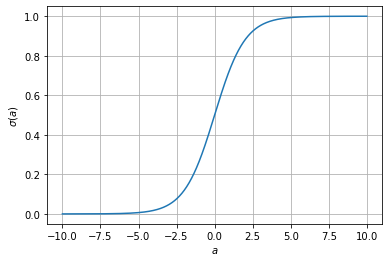

In [8]:
fig, ax = plt.subplots()
x = np.linspace(-10, 10, 1000)
ax.plot(x, 1 / (1 + np.exp(-x)))
ax.set_xlabel('$a$')
ax.set_ylabel('$\sigma(a)$')
ax.grid()
plt.show()

この形状から明らかなように、シグモイド関数は、以下の特徴を持つ。

+ $(-\infty, +\infty) \to (0, 1)$の単調増加関数
+ $\lim_{a \to -\infty} \sigma(a) = 0$
+ $\lim_{a \to +\infty} \sigma(a) = 1$
+ $(0, 0.5)$に関して点対称

ゆえに、ロジスティック回帰は線形二値分類モデルの内積値$\bm{x}^\top\bm{w}$をシグモイド関数$\sigma$で確率値に変換していると理解することができる。また、

$$
\begin{align}
 1 - \sigma(a) = \frac{\left\{1 + e^{-a}\right\} - 1}{1 + e^{-a}} = \frac{e^{-a}}{1 + e^{-a}} = \frac{e^a e^{-a}}{e^a(1 + e^{-a})} = \frac{1}{1 + e^a} = \sigma(-a)
\end{align}
$$ (eq:sigmoid-negative)

であるから、

\begin{align}
 P(\hat{y} = 1|\bm{x}) &= \sigma(\bm{x}^\top \bm{w}) \\
 P(\hat{y} = 0|\bm{x}) &= 1 - P(\hat{y} = 1|\bm{x}) = 1 - \sigma(\bm{x}^\top \bm{w}) = \sigma(-\bm{x}^\top \bm{w})
\end{align}

なお、事例$\bm{x}$を$\hat{y}=1$と予測する確率が$0.5$を上回る条件を求めると、線形二値分類の判別式{eq}`eq:binary-classification`と整合することが確認できる。
\begin{align}
 P(\hat{y} = 1|\bm{x}) > 0.5 \Leftrightarrow \frac{1}{1 + \exp\left(-\bm{x}^\top \bm{w}\right)} > \frac{1}{2} \Leftrightarrow 2 > 1 + \exp\left(-\bm{x}^\top \bm{w}\right) \Leftrightarrow \bm{x}^\top \bm{w} > 0
\end{align}

### シグモイド関数の実装

シグモイド関数$\sigma(a)$を素直に実装すると、以下のようなプログラムになるであろう。

In [2]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [4]:
sigmoid(0)

0.5

In [5]:
sigmoid(3), sigmoid(-3)

(0.9525741268224334, 0.04742587317756678)

ところが、$a=-1000$とすると$e^{1000}$の計算でオーバーフローが発生する。

In [7]:
sigmoid(-1000.)

<ipython-input-2-d5641a12eae7>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-a))


0.0

この問題を回避するには、式{eq}`eq:sigmoid-negative`より$\sigma(-a) = 1 - \sigma(a)$であることを利用し、`np.exp`の計算結果が大きくならないようにすればよい。

In [8]:
def sigmoid(a):
    if 0 <= a:
        return 1 / (1 + np.exp(-a))
    else:
        return 1. - 1 / (1 + np.exp(a))

In [9]:
sigmoid(-1000.)

0.0

## データの表現

分類問題のデータの表現方法は回帰と同様である。説明変数と目的変数の一つの組を学習事例として表現する。$1$番目の学習事例を$(\bm{x}_1, y_1)$、$2$番目の学習事例を$(\bm{x}_2, y_2)$、$i$番目の学習事例を$(\bm{x}_i, y_i)$と表すことにすると、$N$個の事例からなるデータ$\mathcal{D}$は次のように表される。
\begin{align}
\mathcal{D} = \left\{(\bm{x}_1, y_1), (\bm{x}_2, y_2), \dots, (\bm{x}_N, y_N)\right\} = \left\{(\bm{x}_i, y_i)\right\}_{i=1}^{N}
\end{align}

以降では、2個の学習事例（$N=2$）からなる単純なデータ$\mathcal{D}_{s}$を例として用いる。
\begin{align}
\mathcal{D}_s &= \left\{(\bm{x}_i, y_i)\right\}_{i=1}^{2} = \left\{(\bm{x}_1, y_1), (\bm{x}_2, y_2)\right\} \\
 (\bm{x}_1, y_1) &= \left(\begin{pmatrix}
1 & 0 & 1 & 1 & 1 & 1 & 0 & 1 & 1
\end{pmatrix}^\top, 0\right) \\
 (\bm{x}_2, y_2) &= \left(\begin{pmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 1 & 1 & 1
\end{pmatrix}^\top, 1\right)
\end{align}

なお、学習データ$\mathcal{D}_{s}$はトイ・データではあるが、スパム判定の例と対応付けて理解できるように、メールを$\mathcal{D}_{s}$に変換するまでの過程を簡単に説明しておく。先ほどの$d=9$次元の特徴空間を用いたスパムメール判定の例の通り、メールは$9$次元の事例ベクトル$\bm{x}$で表現され、$1$次元目から$8$次元目まで、各次元はメール本文中に"attached", "darling", "file", "hi", "kyoto", "mark", "my", "photo"が含まれるならば$1$、含まれなければ$0$である。$9$次元目はメールの内容に関わらず常に$1$としておく。いま、スパム判定器の学習データとして、以下の2つのメールがあるとすると、先ほどの学習データ$\mathcal{D}_s$が得られる。

+ 学習事例1（スパムではない）: "Hi Mark, Kyoto photo in attached file"
+ 学習事例2（スパム）: "Hi darling, my photo in attached file"

なお、分類モデルは特徴ベクトル（説明変数）を通してのみ、メールなどの入力を観測できる。したがって、分類が成功しやすくなるような特徴空間を定義することは、分類器の性能を向上させるために極めて重要である。

## 尤度

さて、何らかの方法でモデルのパラメータ$\bm{w}$を以下のように決定したとしよう。

\begin{align}
\bm{w} = \begin{pmatrix}
1 & 2 & 0 & 0 & 0 & -1 & 1 & 1 & -2
\end{pmatrix}^\top
\end{align}

ここで、$\mathcal{D}_s$中の事例$\bm{x}_1$に対してロジスティック回帰モデルを適用する。

\begin{gather}
 \bm{x}_1^\top \bm{w} = \begin{pmatrix}
1 & 0 & 1 & 1 & 1 & 1 & 0 & 1 & 1
\end{pmatrix} \begin{pmatrix}
1 & 2 & 0 & 0 & 0 & -1 & 1 & 1 & -2
\end{pmatrix}^\top = -1 \\
P(\hat{y} = 1|\bm{x}_1) = \sigma(\bm{x}_1^\top \bm{w}) = \sigma(-1) \approx 0.269
\end{gather}

ゆえに、$P(\hat{y} = 1|\bm{x}_1) = 0.269$であるから、このモデルは与えられたメールがスパムである確率を$0.269$と予測し、その確率が$0.5$を超えないことから、$\bm{x}_1$はスパムメールではないと判定している。

これまでの流れは、事例$\bm{x}_1$とモデルのパラメータ$\bm{w}$が与えられた時、予測結果$P(\hat{y} = 1|\bm{x}_1) = 0.269$を計算するものであった。ここで、学習事例$(\bm{x}_1, y_1)$は不変（"Hi Mark, Kyoto photo in attached file"というメールがスパムではないのは事実）であると考える。そして、確率に対する見方を変えて、このモデルのパラメータ$\bm{w}$が与えられた学習事例を正しく判定できる確率、すなわちモデルパラメータ$\bm{w}$の学習事例$(\bm{x}, y)$に対する**尤度**$\hat{l}_{\bm{x}, y}(\bm{w})$を次式で定義する。

\begin{gather}
\hat{l}_{\bm{x}, y}(\bm{w}) = P(\hat{y} = y | \bm{x})
\end{gather}

この学習事例に対する尤度は、モデルのパラメータが「どのくらい学習事例を正しく再現できるか」を定量化した指標と見なすことができる。尤度が$1$に近いほど学習事例を正しく再現できていること、$0$に近づくほど学習事例を間違って（例えば$y=0$なのに$\hat{y}=1$と予測して）再現していることを意味する。

例えば、学習事例$(\bm{x}_1, y_1)$は$y_1 = 0$であるから、この学習事例に対するモデルパラメータ$\bm{w}$の尤度は、

\begin{gather}
\hat{l}_{\bm{x}_1, y_1}(\bm{w}) = P(\hat{y} = 0|\bm{x}_1) = 1 - P(\hat{y} = 1|\bm{x}_1) = 1 - 0.269 = 0.731
\end{gather}

これは、モデルパラメータ$\bm{w}$が学習事例$(\bm{x}_1, y_1)$を$0.731$の確率で正しく分類できることを表している。

続いて、$\mathcal{D}_s$中の事例$\bm{x}_2$に対してロジスティック回帰モデルを適用する。

\begin{gather}
 \bm{x}_2^\top \bm{w} = \begin{pmatrix}
1 & 1 & 1 & 1 & 0 & 0 & 1 & 1 & 1
\end{pmatrix} \begin{pmatrix}
1 & 2 & 0 & 0 & 0 & -1 & 1 & 1 & -2
\end{pmatrix}^\top = 3 \\
P(\hat{y} = 1|\bm{x}_2) = \sigma(\bm{x}_2^\top \bm{w}) = \sigma(3) \approx 0.953
\end{gather}

ゆえに、このモデルは与えられたメールがスパムである確率を$0.953$と推定し、その確率が$0.5$を超えていることから、$\bm{x}_2$はスパムメールである可能性が高いと判定している。また、モデルパラメータ$\bm{w}$の学習事例$(\bm{x}_2, y_2)$に対する尤度$\hat{l}_{\bm{x}_2, y_2}(\bm{w})$は、
\begin{gather}
\hat{l}_{\bm{x}_2, y_2}(\bm{w}) = P(\hat{y} = 1|\bm{x}_2) = 0.953
\end{gather}

これは、モデルパラメータ$\bm{w}$が学習事例$(\bm{x}_2, y_2)$を$0.953$の確率で正しく分類できることを表している。

なお、学習事例に対する尤度$\hat{l}_{\bm{x}, y}$は、$y=0$と$y=1$で場合分けする代わりに、$y$乗を使ってまとめると、次式で表現できる。

:::{admonition} 事例ごとの尤度
:class: important
$$
\begin{gather}
\hat{l}_{\bm{x}, y}(\bm{w}) = P(\hat{y} = y | \bm{x}) = \begin{cases}
P(\hat{y} = 1 | \bm{x}) & (y = 1\mbox{のとき}) \\
P(\hat{y} = 0 | \bm{x}) & (y = 0\mbox{のとき}) \\
\end{cases}
&= p^{y} (1-p)^{(1 - y)}
\end{gather}
$$ (eq:instance-likelihood)
:::

ここで、

$$
\begin{align}
p = P(\hat{y} = 1 | \bm{x}) = \sigma(\bm{x}^\top \bm{w})
\end{align}
$$ (eq:definition-of-p)

とおいた。

## 最尤推定

先ほどの例では、モデルのパラメータ$\bm{w}$を合理的な値に（手で）調整しておいたので、すべての学習事例を正しく分類できた。しかし、パラメータ$\bm{w}$の値によっては、正しく分類できない学習事例が出てくる。また、両方の学習事例の尤度は学習事例を完全に再現できる値（$1$）を下回っている。パラメータ$\bm{w}$を調整することで、すべての学習事例の尤度を$1$に引き上げ、未知の事例に対する予測性能を向上させることができるかもしれない。先ほどの学習データ$\mathcal{D}_s$の例では、$\bm{w}$をうまく調整することで、
\begin{gather}
\hat{l}_{\bm{x}_1, y_1}(\bm{w}) &= 0.731 \rightsquigarrow 1 \\
\hat{l}_{\bm{x}_2, y_2}(\bm{w}) &= 0.953 \rightsquigarrow 1
\end{gather}
を実現できるかもしれない。

そこで、学習データ$\mathcal{D}$全体における尤度を定義し、モデルのパラメータ$\bm{w}$がどのくらい学習データ$\mathcal{D}$をうまく反映しているのか、定量的に示したい。ここで、学習データのすべての事例は**独立同分布**（i.i.d: independent and identically distributed）である仮定し、学習データ全体の尤度$\hat{L}_{\mathcal{D}}(\bm{w})$を各学習事例の尤度の結合確率として定義する。
\begin{align}
\hat{L}_{\mathcal{D}}(\bm{w}) = \prod_{i=1}^N \hat{l}_{\bm{x}_i, y_i}(\bm{w})
\end{align}
学習データ全体の尤度も$0$から$1$までの値をとり、尤度が$1$に近いほど学習事例を正しく再現できていることを表す。ゆえに、$\hat{L}_{\mathcal{D}}(\bm{w})$を目的関数とみなし、この目的関数の値を最大化するような$\bm{w}^*$を求めることで、学習データ$\mathcal{D}$によく合致するモデルパラメータを求めることができる。尤度が最大になるパラメータを求めることを**最尤推定**（MLE: Maximum Likelihood Estimation）と呼ぶ。

ところで、学習データ全体の尤度は事例の尤度の積であるから、学習事例の数が多くなると$[0, 1]$の範囲の積を繰り返すことになる。これは、コンピュータ上で学習データ上の尤度を計算するとき、アンダーフローの問題（小さい値を精度良く表現できない問題）を引き起こす。そこで、尤度を最大化する代わりに、尤度の対数をとった**対数尤度**を最大化する。対数尤度は、学習事例の尤度の対数$\log \hat{l}_{(\bm{x}_i, y_i)}(\bm{w})$の和として表現できる。
\begin{align}
\log \hat{L}_{\mathcal{D}}(\bm{w}) &= \log \prod_{i=1}^N \hat{l}_{\bm{x}_i, y_i}(\bm{w})
= \sum_{i=1}^N \log \hat{l}_{\bm{x}_i, y_i}(\bm{w})
\end{align}

なお、回帰では目的関数を最小にするパラメータを求めた。二値分類でも目的関数の最小化の問題に書き換えるため、負の対数尤度を目的関数として用いる。最終的に、ロジスティック回帰モデルの学習で最小化する目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\bm{w})$は次式で表される。

:::{admonition} 最尤推定による目的関数
:class: important
\begin{align}
\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\bm{w}) = -\log \hat{L}_{\mathcal{D}}(\bm{w})
= -\sum_{i=1}^N \log \hat{l}_{\bm{x}_i, y_i}(\bm{w})
\end{align}
:::

また、学習時に$L_2$正則化を導入する場合、目的関数は、
\begin{align}
\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MAP}(\bm{w}) &= -\log \hat{L}_{\mathcal{D}}(\bm{w}) + \alpha \|\bm{w}\|^2
= -\sum_{i=1}^N \log \hat{l}_{\bm{x}_i, y_i}(\bm{w}) + \alpha \|\bm{w}\|^2
\end{align}
となる。ここで、$\alpha$ ($\alpha>0$) は$L_2$正則化の係数である。

## 確率的勾配降下法

これまでの議論により、ロジスティック回帰モデルの学習は、目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\bm{w})$を最小にするパラメータ$\bm{w}^*$を求める問題に帰着した。回帰の場合は目的関数を最小にする解析解（閉じた解）を求めることができたが、ロジスティック回帰モデルの目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\bm{w})$は、パラメータ$\bm{w}$に関して偏微分はできるが、その偏微分の値を$\bm{0}$とする解析解を求めることができない。そこで、確率的勾配降下法で目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\bm{w})$を最小にするパラメータ$\bm{w}^*$を求めることにする。

ここで、最尤推定の目的関数$\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\bm{w})$は、
\begin{align}
\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MLE}(\bm{w}) &= -\log \hat{L}_{\mathcal{D}}(\bm{w})
= \sum_{i=1}^N - \log \hat{l}_{\bm{x}_i, y_i}(\bm{w})
\end{align}
であり、事例毎の実数値の和に分解できるため、確率的勾配降下法を適用可能である。

```{margin} ランダムに選んだ事例$(\bm{x}, y)$
前章の説明では、ランダムに選んだ訓練事例を$(\bm{x}_i, y_i)$と事例番号$i$の添字付きで表記していたが、以降の導出で添字を使うと煩雑になるため、事例番号の添字は省略する。
```

確率的勾配降下法がランダムに訓練事例$(\bm{x}, y) \in \mathcal{D}$を選んだとき、その勾配は$- \nabla \log \hat{l}_{\bm{x}, y}(\bm{w})$であるから、確率的勾配降下法によるパラメータ$\bm{w}$の更新式は、

$$
\begin{align}
\bm{w}^{(t+1)} = \bm{w}^{(t)} + \eta_t \nabla \log \hat{l}_{\bm{x}, y}(\bm{w}^{(t)})
\end{align}
$$ (eq:sgd-gradient-update)

となる。確率的勾配降下法でロジスティック回帰モデルのパラメータ推定を行うためには、訓練事例の勾配$\nabla \log \hat{l}_{\bm{x}, y}(\bm{w})$、すなわち訓練事例の対数尤度$\log \hat{l}_{\bm{x}, y}(\bm{w})$の$\bm{w}$に関する偏微分を求めればよい。

学習事例の対数尤度は、式{eq}`eq:instance-likelihood`より、

$$
\begin{align}
\log \hat{l}_{\bm{x}, y}(\bm{w}) &= \log \left(p^{y} (1-p)^{(1 - y)}\right)
= y \log p + (1-y)\log(1-p)
\end{align}
$$ (eq:loss-binary-classification)

と整理できる。ただし、式{eq}`eq:sigmoid`と{eq}`eq:definition-of-p`で表現されているように、$p$は$\bm{w}$と$\bm{x}$に依存していることに注意が必要である。
\begin{align}
p &= \sigma(a) = \frac{1}{1 + e^{-a}} \\
a &= \bm{x}^\top \bm{w}
\end{align}

合成関数の微分より、

$$
\begin{align}
\nabla \log \hat{l}_{\bm{x}, y}(\bm{w})
= \frac{\partial \left(\log \hat{l}_{\bm{x}, y}(\bm{w})\right)}{\partial \bm{w}}
&= \frac{\partial}{\partial \bm{w}} \left\{y \log p + (1 - y) \log (1-p) \right\} \\
&= \left( \frac{y}{p} \cdot \frac{\partial p}{\partial \bm{w}} + \frac{1 - y}{1 - p} \cdot (-1) \cdot \frac{\partial p}{\partial \bm{w}} \right) \\
&= \left(\frac{y}{p} - \frac{1 - y}{1 - p}\right) \cdot \frac{\partial p}{\partial \bm{w}} \\
&= \frac{(1-p) y - p(1 - y)}{p(1 - p)} \cdot \frac{\partial p}{\partial a} \cdot \frac{\partial a}{\partial \bm{w}} \\
&= \frac{y - p y - p + p y}{p(1 - p)} \cdot \frac{\partial p}{\partial a} \cdot \frac{\partial a}{\partial \bm{w}} \\
&= \frac{y - p}{p(1 - p)} \cdot \frac{\partial p}{\partial a} \cdot \frac{\partial a}{\partial \bm{w}} \\
\end{align}
$$ (eq:logress-gradient)

$\frac{\partial p}{\partial a}$はシグモイド関数$\sigma(a)$の微分である。
\begin{align}
\frac{\partial p}{\partial a} = \sigma'(a) &= \frac{\partial}{\partial a}\left(\frac{1}{1 + e^{-a}}\right) \\
&= (-1) \cdot \frac{1}{\left(1 + e^{-a}\right)^2} \cdot \frac{\partial}{\partial a} \left(1 + e^{-a}\right) \\
&= - \frac{1}{\left(1 + e^{-a}\right)^2} \cdot e^{-a} \cdot (-1) \\
&= \frac{1}{1 + e^{-a}} \cdot \frac{e^{-a}}{1 + e^{-a}} \\
&= \sigma(a) \left(1 - \sigma(a)\right) \\
&= p (1 - p)
\end{align}

また、$\frac{\partial a}{\partial \bm{w}}=\bm{x}$であるから、式{eq}`eq:logress-gradient`は、

$$
\begin{align}
\nabla \log \hat{l}_{\bm{x}, y}(\bm{w})
&= \frac{y - p}{p(1 - p)} \cdot \frac{\partial p}{\partial a} \cdot \frac{\partial a}{\partial \bm{w}} \\
&= \frac{y - p}{p(1 - p)} \cdot \{p (1 - p)\} \cdot \bm{x} \\
&= (y - p) \bm{x} \\
\end{align}
$$ (eq:grad-logress)

これを、確率的勾配降下法の反復式{eq}`eq:sgd-gradient-update`に代入すると、

:::{admonition} 確率的勾配降下法によるロジスティック回帰モデルのパラメータ更新式
:class: important
$$
\begin{align}
\bm{w}^{(t+1)} =  \bm{w}^{(t)} + \eta_t (y - p^{(t)}) \bm{x}
\end{align}
$$ (eq:logress-sgd-update)
:::

ただし、$p^{(t)}$は$t$回目の反復時のパラメータ$\bm{w}^{(t)}$で事例$\bm{x}$を分類したとき、その事例が正例$\hat{y}=1$と予測される確率である。
\begin{align}
p^{(t)} = \sigma(\bm{x}^\top \bm{w}^{(t)})
\end{align}

確率的勾配降下法で回帰モデルのパラメータを求めるための反復式{eq}`eq:mra-sgd`と同様に、ある訓練事例における目的変数の真の値$y$とその確率推定値$p$の差を係数として、その事例の特徴ベクトル$\bm{x}$をパラメータベクトルに足し込む形になっているのが興味深い。

### 確率的勾配降下法の更新式の解釈

式{eq}`eq:logress-sgd-update`の反復式の振る舞いを、学習事例が正例（$y=1$）のときと、負例（$y = 0$）に分けて考える。もし、学習事例が正例（$y=1$）のとき、パラメータの更新式は、
\begin{align}
\bm{w}^{(t+1)} &= \bm{w}^{(t)} + \eta_t (1 - p^{(t)}) \bm{x}
\end{align}
である。この更新後のパラメータ$\bm{w}^{(t+1)}$で同じ事例$\bm{x}$との内積を計算すると、
\begin{align}
\bm{x}^\top\bm{w}^{(t+1)} &= \bm{x}^\top\bm{w}^{(t)} + \eta_t (1 - p^{(t)}) \underbrace{\bm{x}^\top\bm{x}}_{\geq 0} \geq \bm{x}^\top\bm{w}^{(t)}
\end{align}
であるから、更新後のパラメータの内積$\bm{x}^\top\bm{w}^{(t+1)}$は、更新前のパラメータの内積値$\bm{x}^\top\bm{w}^{(t)}$以上にとなり、その変化量は$\eta_t (1 - p^{(t)}) \bm{x}^\top\bm{x}$である。ここで、学習率$\eta_t$は学習事例に依存しない。また、$\bm{x}^\top\bm{x}$もパラメータ$\bm{w}^{(t)}$の値によらない定数と見なすと、内積の変化量は$(1-p^{(t)})$に比例することが分かる。いま、学習事例は正例（$y=1$）であるので、$(1-p^{(t)})$はこの事例に対して予測すべき確率$1$と、実際に計算された確率$p^{(t)}$との差を表している。したがって、モデルのパラメータ$\bm{w}^{(t)}$が学習事例が正例であることをよく予測できている（$p^{(t)} \approx 1$）ならば内積の変化量は小さくなる。逆に、モデルのパラメータ$\bm{w}^{(t)}$が学習事例が正例であることを予測できていない場合（$p^{(t)} \approx 0$）ならば、内積の変化量が大きくなるようにパラメータ$\bm{w}^{(t)}$が更新される。

続いて、学習事例が負例（$y=0$）のとき、パラメータの更新式は、
\begin{align}
\bm{w}^{(t+1)} = \bm{w}^{(t)} + \eta_t (0 - p^{(t)}) \bm{x} = \bm{w}^{(t)} - \eta_t p^{(t)} \bm{x}
\end{align}
である。この更新後のパラメータ$\bm{w}^{(t+1)}$で同じ事例$\bm{x}$との内積を計算すると、
\begin{align}
\bm{x}^\top\bm{w}^{(t+1)} &= \bm{x}^\top\bm{w}^{(t)} - \eta_t p^{(t)} \underbrace{\bm{x}^\top\bm{x}}_{\geq 0} \leq \bm{x}^\top\bm{w}^{(t)}
\end{align}
であるから、更新後のパラメータの内積$\bm{x}^\top\bm{w}^{(t+1)}$は、更新前のパラメータの内積値$\bm{x}^\top\bm{w}^{(t)}$以下にとなり、その変化量は$\eta_t p^{(t)} \bm{x}^\top\bm{x}$である。先ほどの正例の議論と同様に、内積の変化量は$p^{(t)}$に比例することが分かる。いま、学習事例は負例（$y=0$）であるので、$p^{(t)}$はこの事例に対して予測すべき確率$0$と、実際に計算された確率$p^{(t)}$との差を表している。したがって、学習事例が負例であることをモデルのパラメータ$\bm{w}^{(t)}$がよく予測できている（$p^{(t)} \approx 0$）ならば内積の変化量は小さくなる。逆に、学習事例が負例であることをモデルのパラメータ$\bm{w}^{(t)}$があまり予測できていない場合（$p^{(t)} \approx 1$）、内積の変化量が大きくなるようにパラメータ$\bm{w}^{(t)}$が更新される。

### $L_2$正則化付きロジスティック回帰

学習時に$L_2$正則化を導入する場合、目的関数は、
\begin{align}
\hat{\mathcal{L}}_{\mathcal{D}}^{\rm MAP}(\bm{w}) &= -\log \hat{L}_{\mathcal{D}}(\bm{w}) + \alpha \|\bm{w}\|^2 \\
&= -\sum_{i=1}^N \log \hat{l}_{\bm{x}_i, y_i}(\bm{w}) + \alpha \|\bm{w}\|^2 \\
&= \sum_{i=1}^N \left(-\log \hat{l}_{\bm{x}_i, y_i}(\bm{w}) + \frac{\alpha}{N} \|\bm{w}\|^2 \right)\\
\end{align}
と整理できるので、確率的勾配降下法を適用できる。確率的勾配降下法がランダムに選んだ学習事例を$(\bm{x}, y)$とすると、その損失$l_{\bm{x}, y}(\bm{w})$は、
\begin{align}
l_{\bm{x}, y}(\bm{w}) = -\log \hat{l}_{\bm{x}, y}(\bm{w}) + \frac{\alpha}{N} \|\bm{w}\|^2
\end{align}
である。この勾配$\nabla l_{\bm{x}, y}(\bm{w})$を求めるために、$\bm{w}$で偏微分すると、
\begin{align}
\nabla l_{\bm{x}, y}(\bm{w}) = \frac{\partial l_{\bm{x}, y}(\bm{w})}{\partial \bm{w}}
&= \frac{\partial }{\partial \bm{w}}\left(-\log \hat{l}_{\bm{x}, y}(\bm{w}) + \frac{\alpha}{N} \|\bm{w}\|^2\right) \\
&= - \frac{\partial \left(\log \hat{l}_{\bm{x}, y}(\bm{w})\right)}{\partial \bm{w}} + \frac{\partial}{\partial \bm{w}} \left(\frac{\alpha}{N} \|\bm{w}\|^2\right)\\
&= - (y-p) \bm{x} + \frac{2\alpha}{N} \bm{w}
\end{align}

これを、確率的勾配降下法の反復式に代入すると、
\begin{align}
\bm{w}^{(t+1)} &= \bm{w}^{(t)} - \eta_t \left.\frac{\partial l_{\bm{x}, y}(\bm{w})}{\partial \bm{w}}\right|_{\bm{w} = \bm{w}^{(t)}} \\
&= \bm{w}^{(t)} + \eta_t \left\{(y - p) \bm{x} - \frac{2\alpha}{N} \bm{w}^{(t)}\right\} \\
&= \left(1 - \frac{2\alpha\eta_t}{N}\right) \bm{w}^{(t)} + \eta_t (y - p) \bm{x}
\end{align}
リッジ回帰と同様に、パラメータの重みを減衰させる係数$(1 - \frac{2\alpha\eta_t}{N})$が現れる。

## 評価

さて、学習によって獲得した二値分類モデルの性能（分類の正しさ）をどのように評価すればよいか。回帰のときは、学習で用いた目的関数、すなわち平均二乗残差を使って検証データやテストデータ上の性能を測定した。ロジスティック回帰モデルを最尤推定で学習する場合、尤度（もしくは対数尤度）を最大化していたので、検証データやテストデータ上で尤度を測定すればよい（実際に尤度が評価に用いられることもある）。ところが、尤度は人間にとって分かりやすい指標ではないため、二値分類ではもう少し分かりやすい評価尺度が用いられる。ここでは、二値分類モデルの評価尺度として、正解率、適合率、再現率、F1スコアを紹介する。

これらの尺度を説明する前に、**真陽性**（TP: true positive）、**偽陽性**（FP: false positive）、**偽陰性**（FN: false negative）、**真陰性**（TN: true negative）の概念を理解する必要がある。モデルが正例と予測（$\hat{y}=1$）した事例のうち、実際に正例（$y=1$）である事例を真陽性、実際には負例（$y=0$）である事例を疑陽性と呼ぶ。一方、モデルが負例と予測（$\hat{y}=0$）した事例のうち、実際に負例（$y=0$）である事例を真陰性、実際には正例（$y=1$）である事例を偽陰性と呼ぶ。これらの概念を表に表すと、以下のようになる。

<img src="fig/tpfpfntn.svg" alt="混同行列" width="480px">

ここで、真陽性、偽陽性、偽陰性、真陰性の事例数をそれぞれ、${\rm TP}$, ${\rm FP}$, ${\rm FN}$, ${\rm TN}$と書くことにすると、正解率$A$、適合率$P$、再現率$R$、F1スコア$F_1$は、

:::{important}
\begin{gather}
A = \frac{\mbox{システムの正しい予測事例数}}{\mbox{評価した全事例数}} = \frac{{\rm TP} + {\rm TN}}{{\rm TP} + {\rm TN} + {\rm FP} + {\rm FN}}
\end{gather}
\begin{gather}
P = \frac{\mbox{システムが正しく正例と予測した事例数}}{\mbox{システムが正例と予測した事例数}} = \frac{{\rm TP}}{{\rm TP} + {\rm FP}}
\end{gather}
\begin{gather}
R = \frac{\mbox{システムが正しく正例と予測した事例数}}{\mbox{評価データ中の正例の事例数}} = \frac{{\rm TP}}{{\rm TP} + {\rm FN}}
\end{gather}
\begin{gather}
F_1 = \frac{P \times R}{\frac{1}{2}(P + R)} = \frac{2PR}{P + R}
\end{gather}
:::

この中で最も分かりやすい尺度は**正解率**（accuracy）であろう。正解率は、すべての評価事例の中でモデルが予測に成功した割合である。スパム判定の例では、届いたメールに対して、スパム判定の結果が正しかった割合を表す。ただし、評価データ中の正例と負例の割合が大きく偏っている場合、正解率は高くなりやすい。例えば、100件中1件しかスパムメールがやってこない状況では、すべてのメールを「スパムでない」と判定しても正解率が0.99となる。

適合率と再現率はセットで理解する必要がある。**適合率**（precision）は、モデルが正例と予測した事例のうち、実際に正例である事例の割合である。スパム判定の例では、スパムと判定されたメールのうち、実際にスパムであるメールの割合である。スパム判定において適合率が低いと、本当はスパムではないメールがスパムフォルダに自動仕分けされてしまうことになる。一方、**再現率**（recall）は、実際に正例である事例のうち、モデルが正例として予測できる事例の割合である。スパム判定の例では、スパムメールの何割を自動的に認識できるかを表す。スパム判定において再現率が低いと、スパムメールがスパムフォルダに自動仕分けされず、新着メールとして頻繁に表示されてしまうことになる。

一般に、適合率と再現率はトレードオフの関係にある。スパムメールの判定の適合率を高めるには、自信を持ってスパムメールと判定できるものだけスパムと判定し、あまり自信がない事例についてはスパムではないと判定すればよい。ところが、このようにして適合率を高めると、スパムメールと判定することに消極的となり、再現率が低下する。一方、再現率を高めるには、スパムメールと認定する基準を下げ、より多くのメールをスパムとして判定できるように調整すればよい。ところが、メールをスパムとして積極的に判定しすぎると、適合率が低下する。従って、モデルの性能を評価するときは、適合率と再現率の両方を測定することが望ましい。スパムメール判定では、スパムフォルダに自動的に仕分けされてしまったメールは読まれないことになってしまうため、再現率よりも適合率を重視すべきである。

このように、適合率と再現率はトレードオフの関係にあるため、分類器の性能を測定するときにはこの両方の尺度の数値を見る必要がある。この適合率と再現率の調和平均をとったものが**F1スコア**である。F1スコアは異なるモデル間の性能を一つの評価尺度で比較できるので便利である。

なお、病気などの検査では感度（sensitivity）と特異度（specificity）もよく用いられる。感度は再現率と同じ定義であり、実際に陽性となるべき事例をどの程度陽性として検出できたかを表す。特異度は負例に関する再現率であり、実際に陰性となるべき事例をどの程度陰性として検出できたかを表す。特異度（$S$）の定義は次式の通りである。

\begin{align}
S &= \frac{\mbox{システムが正しく負例と予測した事例数}}{\mbox{評価データ中の負例の事例数}} = \frac{{\rm TN}}{{\rm TN} + {\rm FP}}
\end{align}

## スパムフィルタの構築

### データのダウンロード

[SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)を用いて、英語のスパムフィルタを学習する。

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

--2021-08-01 06:20:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   249KB/s    in 0.8s    

2021-08-01 06:20:43 (249 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]



ダウンロードしたファイルを解凍する。

In [4]:
!unzip smsspamcollection.zip

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


データのファイル（SMSSpamCollection）は、１行１事例で書かれており、各事例はラベルとテキストのタブ区切り形式である。スパムではないメッセージは"ham"、スパムメッセージは"spam"としてラベル付けされている。

In [5]:
!head SMSSpamCollection

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

:::{admonition} Windows版PythonなどでLinuxコマンドを利用できない場合
:class: note, dropdown

上の3つのコードセルでは、`!`を先頭に付けることでLinuxコマンドを呼び出している。ところが、Windows版のPython上で動作しているJupyterでは、Linuxコマンドを実行できない。その代替として、以下のPythonプログラムを実行すればよい。

wgetコマンドの代わりに[SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)をダウンロードするコード。

```python
import urllib.request
filename, _ = urllib.request.urlretrieve(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip',
    'smsspamcollection.zip'
)
```

zipコマンドの代わりにダウンロードしたファイルを解凍する。

```python
import zipfile
with zipfile.ZipFile(filename, 'r') as fi:
    fi.extractall('.')
```

解凍したファイルの先頭から10行を表示する。

```python
with open('SMSSpamCollection', encoding="utf-8") as fi:
    for n, line in enumerate(fi):
        if n < 10:
            print(line, end='')
        else:
            break
```

なお、Windows 10以降では[Windows Subsystem for Linux (WSL)](https://docs.microsoft.com/ja-jp/windows/wsl/install)をインストールすることで、UbuntuなどのLinux ディストリビューションを動作させ、その環境内でJupyterを立ち上げることができる。その場合、LinuxコマンドをJupyterのコードセルから直接呼び出すことが可能である。

:::

### データの読み込み

このファイルから事例を読み込み、リストオブジェクト`D`に格納する。

:::{admonition} Windows版Pythonで文字化けが発生する場合
:class: note, dropdown

Windows版のPythonでは、テキストファイルの読み書きの際の文字コードの規定値がCP932 (Shift_JIS) に設定されていることがある。ところが、SMSSpamCollectionというファイルの文字コードはUTF-8であるため、ファイルの内容を正常に読み込むことができない。その場合は、以下のプログラムで

```python
with open('SMSSpamCollection') as fi:
```

となっている箇所を、

```python
with open('SMSSpamCollection', encoding='utf8') as fi:
```

に変更すればよい。

もしくは、`PYTHONUTF8`という環境変数に`1`をセットした状態でJupyterを立ち上げると、テキストファイルの読み書き時の文字コードの規定値がUTF-8となるので、プログラムを変更しなくてもSMSSpamCollectionをUTF-8のテキストファイルとして読み込むことができる（[PEP 540 -- Add a new UTF-8 Mode](https://www.python.org/dev/peps/pep-0540/)）。

```bat
set PYTHONUTF8=1
```

:::

In [74]:
import collections

def tokenize(s):
    return [t.rstrip('.') for t in s.split(' ')]

def vectorize(tokens):
    return collections.Counter(tokens)

def readiter(fi):
    for line in fi:
        fields = line.strip('\n').split('\t')
        x = vectorize(tokenize(fields[1]))
        y = fields[0]
        yield x, y

with open('SMSSpamCollection') as fi:
    D = [d for d in readiter(fi)]

`D`の各要素はメッセージ中に含まれる単語の出現頻度（`collections.Counter`オブジェクト）とラベルのタプルである。

In [49]:
D[6]

(Counter({'Even': 1,
          'my': 1,
          'brother': 1,
          'is': 1,
          'not': 1,
          'like': 2,
          'to': 1,
          'speak': 1,
          'with': 1,
          'me': 2,
          'They': 1,
          'treat': 1,
          'aids': 1,
          'patent': 1}),
 'ham')

[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)を用いて、このデータセットを訓練データ（90%）と評価データ（10%）に分割する。

In [41]:
from sklearn.model_selection import train_test_split

Dtrain, Dtest = train_test_split(D, test_size=0.1, random_state=0)

訓練データと評価データの事例数を確認しておく。

In [44]:
len(Dtrain), len(Dtest)

(5016, 558)

### データ形式の変換

[sklearn.feature_extraction.DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html)と[sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)を用いて、訓練データと評価データをscikit-learnが扱える行列形式に変換する。

DictVectorizerは、特徴をキー、値をバリューとする辞書オブジェクトから特徴ベクトルに変換する。このとき、各特徴に$0$から始まるID番号を割り振っていくことで、文字列などで表現される特徴をベクトルの要素番号に対応づける。なお、テキストを単語を特徴とするベクトルで表現する場合、ベクトルの要素数はデータ中のすべての単語となるが、各事例のテキストは少数の単語で構成されるため、特徴ベクトルの多くの要素はゼロで、テキストに含まれている単語に対応する要素だけ非ゼロとなる。このように、要素の多くはゼロで、少数の要素が非ゼロであるベクトルは疎ベクトルと呼ばれる。DictVectorizerのデフォルトの動作では、辞書オブジェクトを[scipy.sparse](https://docs.scipy.org/doc/scipy/reference/sparse.html)の疎ベクトル形式に変換する。

[fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer.fit_transform)関数は、
特徴と要素番号の対応関係を更新しながら、辞書オブジェクトを疎ベクトルに変換する。[transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer.transform)関数は、特徴と要素番号の対応関係を更新せずに、辞書オブジェクトを疎ベクトルに変換する（対応関係が登録されていない特徴は無視される）。
学習時に存在しなかった特徴を評価時に使うことができないため、前者を学習データに、後者を評価データに用いる。いずれの関数も、引数として辞書オブジェクトのリスト（事例のリスト）を与えると、返り値は事例の疎ベクトルをまとめた疎行列となる。

LabelEncoderはラベルを整数値に変換する。各ラベルに$0$から始まるID番号を割り振っていくことで、文字列などで表現されるラベルをクラスの番号に対応づける。今回用いるデータは"ham"と"spam"の二つのラベルで構成されているため、これらのラベルに対して$0$または$1$が割り当てられる。

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

VX = DictVectorizer()
VY = LabelEncoder()

Xtrain = VX.fit_transform([d[0] for d in Dtrain])
Ytrain = VY.fit_transform([d[1] for d in Dtrain])
Xtest = VX.transform([d[0] for d in Dtest])
Ytest = VY.transform([d[1] for d in Dtest])

訓練データの事例`Dtrain[10]`がどのように変換されたのか確認しておこう。

In [61]:
Dtrain[10]

(Counter({'I': 1,
          'take': 1,
          'it': 2,
          'we': 3,
          "didn't": 1,
          'have': 2,
          'the': 1,
          'phone': 1,
          'callon': 1,
          'Friday': 1,
          'Can': 1,
          'assume': 1,
          "won't": 1,
          'this': 1,
          'year': 1,
          'now?': 1}),
 'ham')

この事例の特徴ベクトルは疎ベクトルとして表現されている。

In [58]:
print(Xtrain[10])

  (0, 1831)	1.0
  (0, 2385)	1.0
  (0, 2769)	1.0
  (0, 5546)	1.0
  (0, 6110)	1.0
  (0, 6923)	1.0
  (0, 8101)	2.0
  (0, 8587)	2.0
  (0, 9821)	1.0
  (0, 10231)	1.0
  (0, 11832)	1.0
  (0, 11957)	1.0
  (0, 12014)	1.0
  (0, 12653)	3.0
  (0, 12862)	1.0
  (0, 13030)	1.0


値が`3.0`となっているベクトルの列番号は`12653`である。`Dtrain[10]`の実行結果から、この特徴に対応する単語は"we"である。そこで、`12653`に対応づけられている特徴を調べると、"we"であることが確認できる。

In [64]:
VX.feature_names_[12653]

'we'

この事例に対応づけられたラベルのID番号は$0$である。

In [59]:
print(Ytrain[10])

0


LabelEncoderオブジェクトに格納されているラベルからID番号への対応付けを確認すると、"ham"が$0$番、"spam"が$1$番に割り当てられていることが分かる。つまり、$y=0$が"ham"、$y=1$が"spam"に対応付けられている。

In [66]:
VY.classes_

array(['ham', 'spam'], dtype='<U4')

### 二値分類モデルの学習

[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)は線形分類モデルを確率的勾配降下法で学習する。ロジスティック回帰モデルを学習するには、SGDClassifierの引数に`loss='log'`を指定する。[fit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.fit)関数に訓練データを渡すことで、モデルのパラメータが学習される。

In [16]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss='log')
model.fit(Xtrain, Ytrain)

SGDClassifier(loss='log')

### 分類器の適用・評価

学習した分類器のモデルを用い、評価データの先頭の事例を分類する。予測されたラベルのID番号は$0$なので、このメッセージは"ham"（スパムではない）と予測された。

In [67]:
model.predict(Xtest[0])

array([0])

モデルがこの事例を"ham"および"spam"と予測する確率を表示する。

In [17]:
model.predict_proba(Xtest[0])

array([[0.99567905, 0.00432095]])

評価データのすべての事例を使い、正解率を求める。

In [18]:
model.score(Xtest, Ytest)

0.9695340501792115

任意のテキストメッセージを分類モデルに適用する例。以下のメッセージはspamに分類された。

In [89]:
msg = "Your account has been credited with 500 FREE Text Messages."
model.predict_proba(VX.transform(vectorize(tokenize(msg))))

array([[0.30330529, 0.69669471]])

### モデルパラメータの確認

学習で求められたモデルのパラメータ（重み）は`coef_`メンバ変数で確認できる。

In [19]:
model.coef_

array([[-8.37090795e-01, -1.76138728e-01, -7.74805758e-04, ...,
         2.93789017e-02, -3.55600052e-01, -9.90864851e-04]])

特徴を表す単語とその重みのタプルからなるリストを作成し、重みが小さい順に並べたものを変数`F`に格納する。

In [70]:
F = sorted(zip(VX.feature_names_, model.coef_[0]), key=lambda x: x[1])

重みの値が負に大きいトップ20の単語を表示する。$y=0$は"ham"に対応するので、これらの単語を含むメッセージは"ham"と予測されやすくなる。

In [71]:
F[:20]

[('&lt;#&gt;', -1.3558829924814004),
 ('me', -1.303455143586944),
 ('So', -1.14067222707557),
 ('him', -1.0598045974397776),
 ('i', -1.0030856587407084),
 ('my', -0.989036736792116),
 ('?', -0.9782504941221924),
 ('good', -0.9565766623762151),
 ('I', -0.9376350998709289),
 ('Its', -0.8771757171170732),
 ('how', -0.8669824265651959),
 (':)', -0.8547153077528507),
 ('ask', -0.8455262058905626),
 ('Ok', -0.8390078922985393),
 ("I'll", -0.8386832325339574),
 ('', -0.8370907952027454),
 ('something', -0.8358732912496923),
 ('hi', -0.8223764866888945),
 ("i'm", -0.8157132793348036),
 ('&amp;', -0.8138253181689464)]

重みの値が正に大きいトップ20の単語を表示する。$y=1$は"spam"に対応するので、これらの単語を含むメッセージは"spam"と予測されやすくなる。

In [72]:
F[-20:]

[("let's", 1.5410199592235803),
 ('-', 1.546029930147131),
 ('85233', 1.5646354767938881),
 ('FREE>Ringtone!Reply', 1.5646354767938881),
 ('To', 1.5765775613191408),
 ('Reply', 1.6688173510729016),
 ('84484', 1.7389287297155838),
 ('ringtoneking', 1.7389287297155838),
 ('146tf150p', 1.763641194218317),
 ('2/2', 1.763641194218317),
 ('text', 1.7664355866227701),
 ('won', 1.9273478586846209),
 ('service', 1.9282663075223407),
 ('&', 1.928861893331028),
 ('STOP', 2.0508768286731196),
 ('mobile', 2.059881177176412),
 ('now!', 2.112823595204192),
 ('txt', 2.1171488639279636),
 ('Txt', 2.119470386271705),
 ('Call', 2.374054661665122)]

## 確認問題

**(1) 確率的勾配降下法によるロジスティック回帰モデルの学習**

確率的勾配降下法でロジスティック回帰モデルを学習するアルゴリズムを自前で実装せよ。学習データや評価データは自由に選んでよい（難しければ、前節で用いた[SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)を用いよ）。

**(2) 評価データ上での正解率**

評価データ上で学習したモデルの正解率を測定せよ。

**(3) 学習で求めたパラメータ**

学習で求めたモデルのパラメータのうち、重みの絶対値が大きいものトップ20を、重みが正のものと負のものに分けて表示せよ。

---

[機械学習帳](https://chokkan.github.io/mlnote/) © Copyright 2020-2024 by [岡崎 直観 (Naoaki Okazaki)](https://www.chokkan.org/). この作品は<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">クリエイティブ・コモンズ 表示 - 非営利 - 改変禁止 4.0 国際 ライセンス</a>の下に提供されています。 <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/80x15.png" /></a>　ただし、作品中のコードセル部分は<a rel="license" href="https://opensource.org/licenses/MIT">MITライセンス</a>の下に提供されています。